## LeNet-5 on MNIST (PyTorch)
- 经典结构: Conv(6)-AvgPool-Conv(16)-AvgPool-FC(120)-FC(84)-FC(10)
- 激活函数使用 Tanh，池化使用 AvgPool，输入从 28x28 通过 pad -> 32x32
- 几个 epoch 通常即可在 MNIST 上达到 98%+ 准确率

In [1]:
%pip install tqdm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [3]:
# ========== 随机种子 ==========
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

In [4]:
# ========== 配置 ==========
# 检测是否有GPU，若没有则使用cpu
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
                      else "cpu")
#设置batch size，epoch 用于优化器的学习率和momentum
batch_size = 128
epochs = 8
lr = 0.01
momentum = 0.9
num_workers = 2 if os.name != "nt" else 0  # Windows 下设 0 更稳

In [5]:
# ========= 1. 基础预处理（不带数据增强，用于：测试集 + 原始训练集） =========
base_transform = transforms.Compose([
    transforms.Pad(2),              # 28x28 -> 32x32（匹配 LeNet-5）
    transforms.ToTensor(),          # 转成张量 [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 均值/方差
])

# ========= 2. 带数据增强的训练集预处理 =========
train_transform = transforms.Compose([
    transforms.Pad(2),                                # 28x28 -> 32x32
    transforms.RandomRotation(degrees=15),            # 数据扩增 1：随机旋转
    transforms.RandomAffine(                          # 数据扩增 2：随机平移（不再额外旋转）
        degrees=0,
        translate=(0.1, 0.1)                          # 水平/垂直方向最多平移 10%
    ),
    transforms.RandomPerspective(                     # 数据扩增 3：随机透视变换
        distortion_scale=0.2,
        p=0.5
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(                         # 数据扩增 4：随机擦除一小块区域
        p=0.3,
        scale=(0.02, 0.15),
        ratio=(0.3, 3.3)
    ),
])

# ========= 3. 构建原始训练集 + 扩增训练集，并拼接在一起 =========
orig_train_set = datasets.MNIST(
    root="./data", train=True, download=True, transform=base_transform
)

aug_train_set = datasets.MNIST(
    root="./data", train=True, download=False, transform=train_transform
)

# 把“原始版本”和“扩增版本”拼成一个更大的训练集
train_set = ConcatDataset([orig_train_set, aug_train_set])

# 测试集只用基础预处理，不做扩增
test_set = datasets.MNIST(
    root="./data", train=False, download=False, transform=base_transform
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [6]:
# ========== 模型：LeNet-5 ==========
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # C1: 1x32x32 -> 6x28x28 (5x5 conv, no padding)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True)
        # S2: AvgPool 6x28x28 -> 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: 6x14x14 -> 16x10x10
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True)
        # S4: AvgPool 16x10x10 -> 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: 16x5x5 -> 120x1x1  (经典 LeNet-5 的 conv 当作全连接)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, bias=True)

        # F6: 120 -> 84
        self.fc1 = nn.Linear(120, 84)
        # OUTPUT: 84 -> 10
        self.fc2 = nn.Linear(84, num_classes)

        # 经典 LeNet 使用 Tanh
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)
        x = self.act(self.conv3(x))        # [B, 120, 1, 1]
        x = x.view(x.size(0), -1)          # [B, 120]
        x = self.act(self.fc1(x))          # [B, 84]
        x = self.fc2(x)                    # [B, 10]
        return x

In [7]:
model = LeNet5().to(device)
print(model)
# 参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params/1e6:.3f}M")

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
)
Total parameters: 0.062M


In [8]:
# ========== 优化器 & 损失 ==========
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)

# 可选：学习率衰减（余弦或 step）
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [9]:
# ========== 训练/评测函数 ==========
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        pbar.set_description(f"loss {running_loss/total:.4f} | acc {correct/total:.4f}")
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss_sum += loss.item() * imgs.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return loss_sum/total, correct/total

In [10]:
# ========== 训练循环(绘制loss变化曲线) ==========
best_acc = 0.0
save_path = "lenet5_mnist.pt"
t0 = time.time()

train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    # === 记录 loss ===
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch:02d}] "
          f"train_loss={train_loss:.4f} train_acc={train_acc*100:.2f}% | "
          f"test_loss={val_loss:.4f} test_acc={val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "acc": best_acc,
                    "epoch": epoch}, save_path)

t1 = time.time()
print(f"Done. Best test acc: {best_acc*100:.2f}%. Time: {(t1-t0):.1f}s. Model saved to {save_path}")

  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 01] train_loss=0.6445 train_acc=80.50% | test_loss=0.0731 test_acc=97.83%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 02] train_loss=0.1815 train_acc=94.37% | test_loss=0.0493 test_acc=98.35%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 03] train_loss=0.1398 train_acc=95.56% | test_loss=0.0494 test_acc=98.36%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 04] train_loss=0.1217 train_acc=96.20% | test_loss=0.0382 test_acc=98.75%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 05] train_loss=0.1082 train_acc=96.62% | test_loss=0.0330 test_acc=98.91%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 06] train_loss=0.0933 train_acc=97.16% | test_loss=0.0302 test_acc=99.12%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 07] train_loss=0.0904 train_acc=97.15% | test_loss=0.0272 test_acc=99.09%


  0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 08] train_loss=0.0870 train_acc=97.25% | test_loss=0.0295 test_acc=98.98%
Done. Best test acc: 99.12%. Time: 757.3s. Model saved to lenet5_mnist.pt


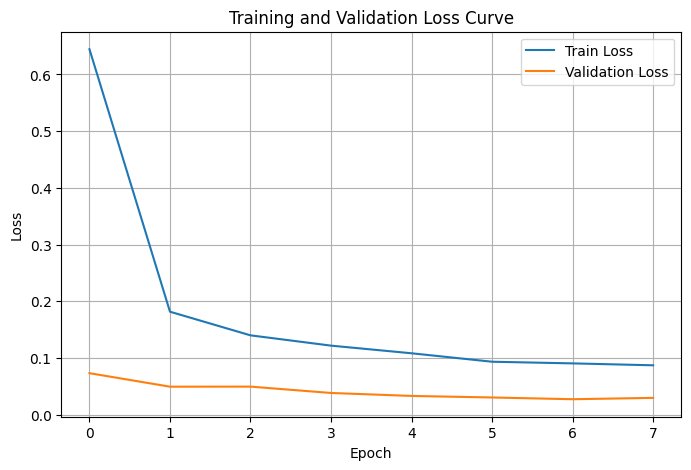

In [11]:
import matplotlib.pyplot as plt

# ========== 训练循环(绘制loss变化曲线) ==========
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import matplotlib.pyplot as plt

# ========== 载入与单样本推理 ==========
@torch.no_grad()
def quick_infer_sample():
    model.eval()
    img, label = test_set[514]         # 取一张测试图片
    x = img.unsqueeze(0).to(device)  # 增加 batch 维度
    logits = model(x)
    pred = logits.argmax(dim=1).item()

    # 打印预测结果
    print(f"GT label: {label}, Pred: {pred}")

    # 可视化图片
    plt.imshow(img.squeeze(0), cmap="gray") 
    plt.title(f"GT:{label}, Pred:{pred}")
    plt.axis("off")
    plt.show()

 

GT label: 6, Pred: 6


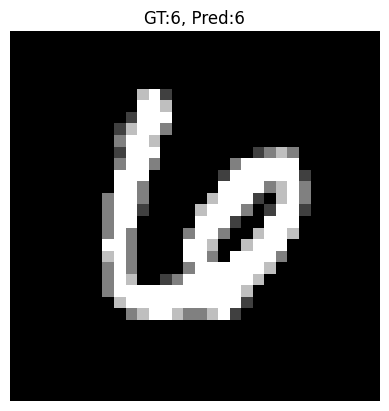

In [13]:
quick_infer_sample() 